# Fake vs Real News Classification - Data Exploration & Preprocessing

This notebook performs exploratory data analysis and preprocessing for the fake news classification project.

## Project Overview
- **Goal**: Build a classifier to distinguish between real (1) and fake (0) news
- **Dataset**: News articles with labels, titles, full text content, subjects, and dates
- **Approach**: Use NLP techniques to process text and train machine learning models
- **Output**: Preprocessed data ready for model training

## Dataset Structure
- `label`: 0 = fake news, 1 = real news
- `title`: Headline text
- `text`: Full article content
- `subject`: Article topic/category
- `date`: Publication date

## Workflow
1. Load and explore the training dataset (`data.csv`)
2. Perform data cleaning and preprocessing
3. Apply text processing techniques (tokenization, TF-IDF, etc.)
4. Split data into training and test sets (stratified by label)
5. Save preprocessed data for model training

## 1. Import Required Libraries

In [16]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Text processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print("NLTK data downloaded successfully!")
except:
    print("NLTK data download failed - please download manually if needed")

Libraries imported successfully!
NLTK data downloaded successfully!


## 2. Load and Explore the Dataset

In [17]:
# Load the training dataset
print("Loading training dataset...")
df = pd.read_csv('../dataset/data.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)

# Display memory usage for large dataset
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nFirst 5 rows:")
df.head()

Loading training dataset...
Dataset Shape: (39942, 5)

Column Names: ['label', 'title', 'text', 'subject', 'date']

Data Types:
label       int64
title      object
text       object
subject    object
date       object
dtype: object

Memory usage: 132.67 MB

First 5 rows:
Dataset Shape: (39942, 5)

Column Names: ['label', 'title', 'text', 'subject', 'date']

Data Types:
label       int64
title      object
text       object
subject    object
date       object
dtype: object

Memory usage: 132.67 MB

First 5 rows:


,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    39942 non-null  int64 
 1   title    39942 non-null  object
 2   text     39942 non-null  object
 3   subject  39942 non-null  object
 4   date     39942 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


In [19]:
# Check for missing values
print("Missing values per column:")
missing_info = df.isnull().sum()
print(missing_info)

# Check data distribution
print("\nLabel distribution (0=fake, 1=real):")
label_counts = df['label'].value_counts().sort_index()
print(label_counts)

# Calculate percentages
print("\nLabel distribution (percentages):")
label_pct = df['label'].value_counts(normalize=True).sort_index() * 100
for label, pct in label_pct.items():
    label_name = 'Fake' if label == 0 else 'Real'
    print(f"  {label_name} (Label {label}): {pct:.1f}%")

# Check subjects
print("\nSubject distribution:")
subject_counts = df['subject'].value_counts()
print(subject_counts.head(10))  # Show top 10 subjects

# Date range analysis
if not df['date'].isnull().all():
    print("\nDate range:")
    try:
        df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
        if df['date_parsed'].notna().any():
            print(f"From: {df['date_parsed'].min()}")
            print(f"To: {df['date_parsed'].max()}")
        else:
            print("Date parsing failed - treating as string")
    except:
        print("Date column contains mixed formats")

Missing values per column:
label      0
title      0
text       0
subject    0
date       0
dtype: int64

Label distribution (0=fake, 1=real):
label
0    19943
1    19999
Name: count, dtype: int64

Label distribution (percentages):
  Fake (Label 0): 49.9%
  Real (Label 1): 50.1%

Subject distribution:
subject
politicsNews       11272
News                9050
worldnews           8727
politics            6841
left-news           2482
Government News     1570
Name: count, dtype: int64

Date range:
From: 2015-03-31 00:00:00
To: 2018-02-19 00:00:00


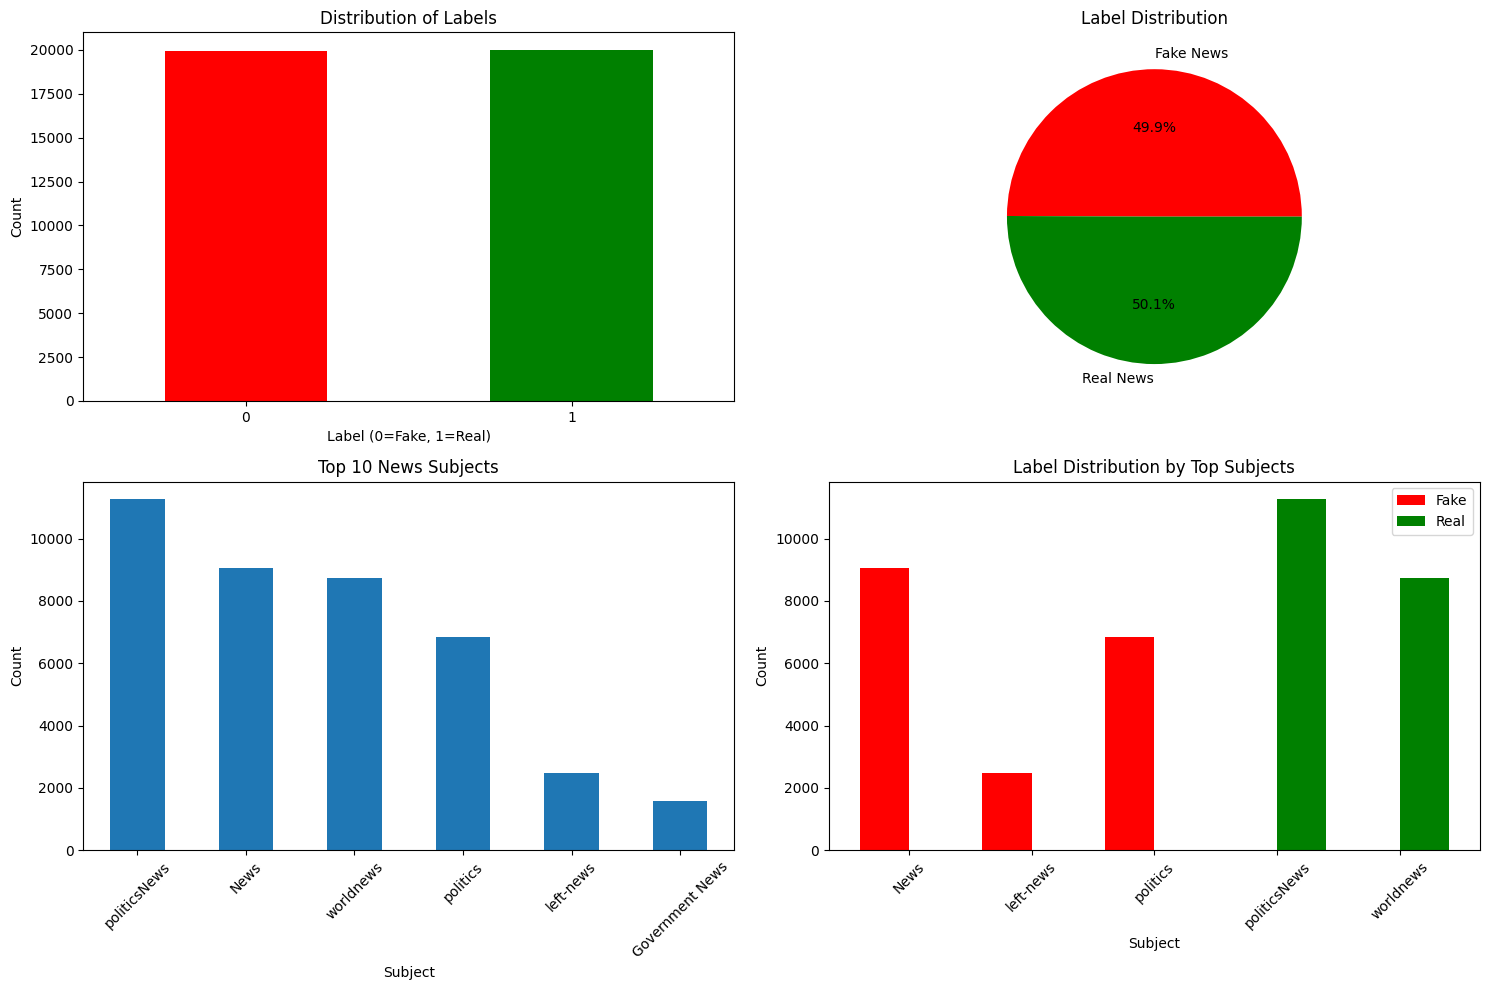


Dataset Summary:
Total articles: 39,942
Fake articles: 19,943 (49.9%)
Real articles: 19,999 (50.1%)
Number of subjects: 6
Articles with missing text: 0
Articles with missing titles: 0


In [20]:
# Visualize label distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Label distribution - Bar plot
label_counts.plot(kind='bar', ax=axes[0, 0], color=['red', 'green'])
axes[0, 0].set_title('Distribution of Labels')
axes[0, 0].set_xlabel('Label (0=Fake, 1=Real)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Label distribution - Pie chart
label_counts.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%', 
                  labels=['Fake News', 'Real News'], colors=['red', 'green'])
axes[0, 1].set_title('Label Distribution')
axes[0, 1].set_ylabel('')

# Subject distribution (top 10)
subject_counts.head(10).plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Top 10 News Subjects')
axes[1, 0].set_xlabel('Subject')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Label distribution by subject (for top subjects)
top_subjects = subject_counts.head(5).index
subject_label_df = df[df['subject'].isin(top_subjects)].groupby(['subject', 'label']).size().unstack(fill_value=0)
subject_label_df.plot(kind='bar', ax=axes[1, 1], color=['red', 'green'], width=0.8)
axes[1, 1].set_title('Label Distribution by Top Subjects')
axes[1, 1].set_xlabel('Subject')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['Fake', 'Real'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics
total_articles = len(df)
fake_articles = len(df[df['label'] == 0])
real_articles = len(df[df['label'] == 1])

print(f"\nDataset Summary:")
print(f"Total articles: {total_articles:,}")
print(f"Fake articles: {fake_articles:,} ({fake_articles/total_articles*100:.1f}%)")
print(f"Real articles: {real_articles:,} ({real_articles/total_articles*100:.1f}%)")
print(f"Number of subjects: {df['subject'].nunique()}")
print(f"Articles with missing text: {df['text'].isnull().sum()}")
print(f"Articles with missing titles: {df['title'].isnull().sum()}")

In [21]:
# Analyze subject distribution to check for data leakage
print("SUBJECT ANALYSIS - CHECKING FOR DATA LEAKAGE")
print("=" * 50)

# Check if subject is a perfect predictor (100% correlation with label)
subject_label_analysis = df.groupby(['subject', 'label']).size().reset_index(name='count')
subject_totals = df.groupby('subject').size().reset_index(name='total')
subject_analysis_merged = subject_label_analysis.merge(subject_totals, on='subject')
subject_analysis_merged['percentage'] = (subject_analysis_merged['count'] / subject_analysis_merged['total']) * 100

print("Subject-Label Analysis:")
print(subject_analysis_merged.pivot(index='subject', columns='label', values='percentage').fillna(0).round(1))

# Check if any subject has 100% of one label (indicating perfect prediction)
perfect_predictors = []
for subject in df['subject'].unique():
    subject_data = df[df['subject'] == subject]['label']
    if len(subject_data.unique()) == 1:  # Only one label type
        perfect_predictors.append(subject)
        label_type = 'Fake' if subject_data.iloc[0] == 0 else 'Real'
        count = len(subject_data)
        print(f"⚠️  '{subject}': 100% {label_type} ({count:,} articles)")

if len(perfect_predictors) > 0:
    print(f"\n🚨 DATA LEAKAGE DETECTED!")
    print(f"Found {len(perfect_predictors)} subjects that are 100% predictors of the label.")
    print(f"This means 'subject' is a perfect predictor and should NOT be used for training.")
    print(f"Using 'subject' would lead to overfitting and poor generalization to real-world data.")
    
    # Calculate how many articles would be perfectly predicted by subject alone
    perfect_prediction_count = df[df['subject'].isin(perfect_predictors)].shape[0]
    total_articles = len(df)
    print(f"\nArticles that would be perfectly predicted by subject: {perfect_prediction_count:,} / {total_articles:,} ({perfect_prediction_count/total_articles*100:.1f}%)")
    
else:
    print("\nNo perfect subject predictors found - subject column could be useful for training.")

print(f"\n📊 DECISION: DROP 'subject' COLUMN")
print(f"The subject column shows perfect correlation with labels for some categories,")
print(f"indicating data leakage. We will exclude it from our model to ensure")
print(f"the classifier learns from actual text content, not metadata shortcuts.")

# Drop the subject column from our dataset
print(f"\nDropping 'subject' column from dataset...")
df_no_subject = df.drop(columns=['subject'])
print(f"Dataset shape before: {df.shape}")
print(f"Dataset shape after: {df_no_subject.shape}")
print(f"✓ Subject column removed to prevent data leakage")

# Update our main dataframe
df = df_no_subject.copy()

print(f"\nRemaining columns: {df.columns.tolist()}")

SUBJECT ANALYSIS - CHECKING FOR DATA LEAKAGE
Subject-Label Analysis:
label                0      1
subject                      
Government News  100.0    0.0
News             100.0    0.0
left-news        100.0    0.0
politics         100.0    0.0
politicsNews       0.0  100.0
worldnews          0.0  100.0
⚠️  'politicsNews': 100% Real (11,272 articles)
⚠️  'worldnews': 100% Real (8,727 articles)
⚠️  'News': 100% Fake (9,050 articles)
⚠️  'politics': 100% Fake (6,841 articles)
⚠️  'Government News': 100% Fake (1,570 articles)
⚠️  'left-news': 100% Fake (2,482 articles)

🚨 DATA LEAKAGE DETECTED!
Found 6 subjects that are 100% predictors of the label.
This means 'subject' is a perfect predictor and should NOT be used for training.
Using 'subject' would lead to overfitting and poor generalization to real-world data.

Articles that would be perfectly predicted by subject: 39,942 / 39,942 (100.0%)

📊 DECISION: DROP 'subject' COLUMN
The subject column shows perfect correlation with labels f

In [22]:
# extract month year for each date entry
df['month_year'] = pd.to_datetime(df['date'], errors='coerce').dt.to_period('M')
month_year_counts = df['month_year'].value_counts().sort_index() 

In [23]:
month_year_counts

month_year
2015-03       6
2015-04     205
2015-05     225
2015-06     159
2015-07     208
2015-08     172
2015-09     162
2015-10     222
2015-11     176
2015-12     204
2016-01    1147
2016-02    1287
2016-03    1355
2016-04    1167
2016-05    1193
2016-06    1094
2016-07    1020
2016-08     988
2016-09    1109
2016-10    1326
2016-11    1495
2016-12    1249
2017-01    1659
2017-02    1396
2017-03    1634
2017-04    1294
2017-05    1306
2017-06    1322
2017-07    1267
2017-08    1156
2017-09    2460
2017-10    3705
2017-11    3587
2017-12    2944
2018-02      35
Freq: M, Name: count, dtype: int64

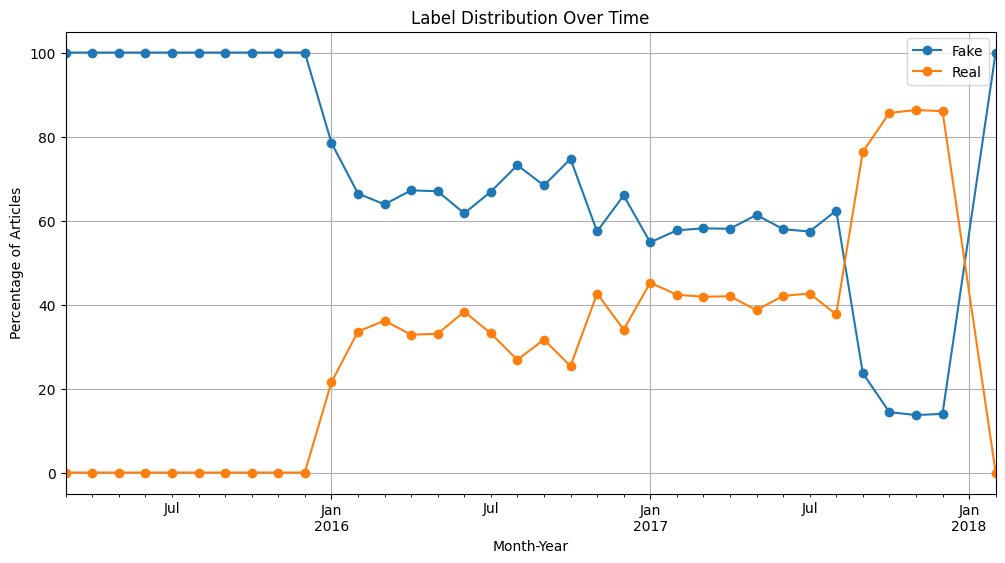

In [24]:
# show label distribution over as percentage
label_time_df = df.groupby(['month_year', 'label']).size().unstack(fill_value=0)
label_time_df = label_time_df.div(label_time_df.sum(axis=1), axis=0) * 100
label_time_df.plot(kind='line', figsize=(12, 6), marker='o')
plt.title('Label Distribution Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Percentage of Articles')
plt.legend(['Fake', 'Real'])
plt.grid()
plt.show()

Analyzing text lengths...
Text Statistics by Label (0=Fake, 1=Real):

1. Title Character Length:
         count       mean        std   min   25%   50%    75%    max
label                                                               
0      19943.0  94.964198  26.228030   8.0  79.0  90.0  104.0  286.0
1      19999.0  64.627781   9.164156  26.0  59.0  64.0   70.0  133.0

2. Article Text Character Length:
         count         mean          std  min     25%     50%     75%      max
label                                                                         
0      19943.0  2377.988969  1832.900687  1.0  1498.0  2176.0  2961.0  49705.0
1      19999.0  2391.268163  1696.464495  1.0   899.5  2231.0  3254.5  29781.0

3. Title Word Count:
         count       mean       std  min   25%   50%   75%   max
label                                                           
0      19943.0  14.843404  4.215523  1.0  12.0  14.0  17.0  42.0
1      19999.0   9.949197  1.702060  4.0   9.0  10.0  11.0 

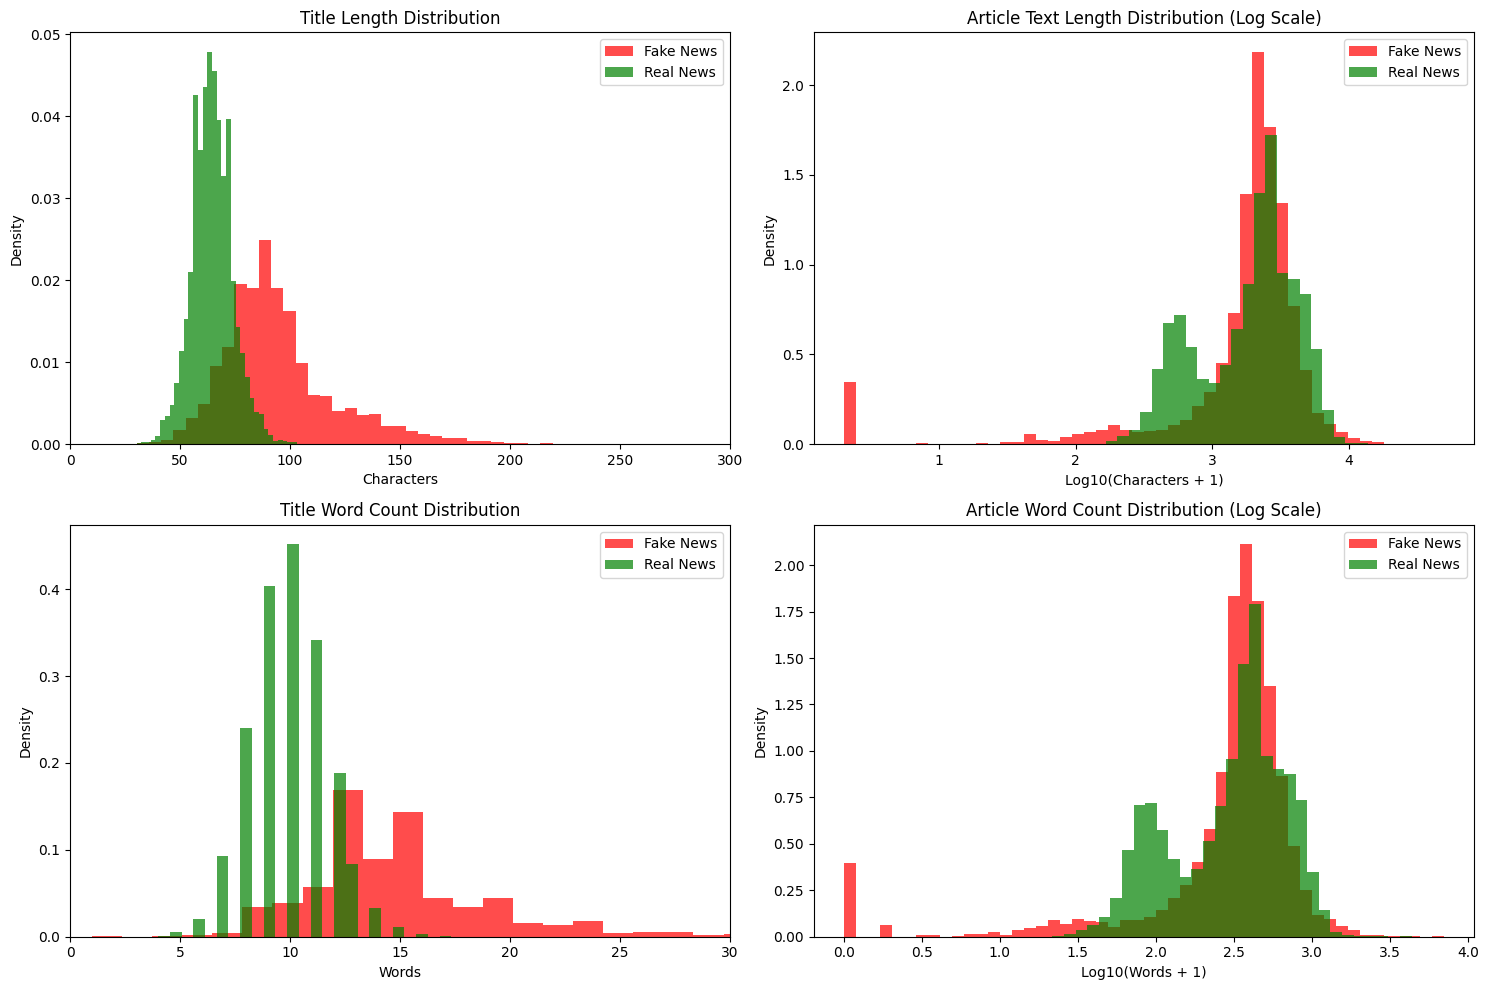

In [25]:
# Text length analysis for text columns
print("Analyzing text lengths...")

# Calculate text statistics
df['title_length'] = df['title'].astype(str).str.len()
df['text_length'] = df['text'].astype(str).str.len()
df['title_word_count'] = df['title'].astype(str).str.split().str.len()
df['text_word_count'] = df['text'].astype(str).str.split().str.len()

# Statistics by label
print("Text Statistics by Label (0=Fake, 1=Real):")
print("\n1. Title Character Length:")
title_stats = df.groupby('label')['title_length'].describe()
print(title_stats)

print("\n2. Article Text Character Length:")
text_stats = df.groupby('label')['text_length'].describe()
print(text_stats)

print("\n3. Title Word Count:")
title_word_stats = df.groupby('label')['title_word_count'].describe()
print(title_word_stats)

print("\n4. Article Text Word Count:")
text_word_stats = df.groupby('label')['text_word_count'].describe()
print(text_word_stats)

# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Title lengths by label
for label in [0, 1]:
    label_name = 'Fake' if label == 0 else 'Real'
    color = 'red' if label == 0 else 'green'
    data = df[df['label'] == label]['title_length']
    axes[0, 0].hist(data, bins=50, alpha=0.7, label=f'{label_name} News', color=color, density=True)
axes[0, 0].set_title('Title Length Distribution')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 300)

# Text lengths by label (log scale for better visualization)
for label in [0, 1]:
    label_name = 'Fake' if label == 0 else 'Real'
    color = 'red' if label == 0 else 'green'
    data = df[df['label'] == label]['text_length']
    axes[0, 1].hist(np.log10(data + 1), bins=50, alpha=0.7, label=f'{label_name} News', color=color, density=True)
axes[0, 1].set_title('Article Text Length Distribution (Log Scale)')
axes[0, 1].set_xlabel('Log10(Characters + 1)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Title word counts
for label in [0, 1]:
    label_name = 'Fake' if label == 0 else 'Real'
    color = 'red' if label == 0 else 'green'
    data = df[df['label'] == label]['title_word_count']
    axes[1, 0].hist(data, bins=30, alpha=0.7, label=f'{label_name} News', color=color, density=True)
axes[1, 0].set_title('Title Word Count Distribution')
axes[1, 0].set_xlabel('Words')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].set_xlim(0, 30)

# Text word counts (log scale)
for label in [0, 1]:
    label_name = 'Fake' if label == 0 else 'Real'
    color = 'red' if label == 0 else 'green'
    data = df[df['label'] == label]['text_word_count']
    axes[1, 1].hist(np.log10(data + 1), bins=50, alpha=0.7, label=f'{label_name} News', color=color, density=True)
axes[1, 1].set_title('Article Word Count Distribution (Log Scale)')
axes[1, 1].set_xlabel('Log10(Words + 1)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Cleaning

In [26]:
# Handle missing values and data cleaning
print("Data Cleaning and Missing Value Handling")
print("=" * 50)

# Before cleaning
print("BEFORE CLEANING:")
print(f"Dataset shape: {df.shape}")
print("\nMissing values:")
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"  {col}: {missing_count} ({missing_count/len(df)*100:.1f}%)")

# Handle missing values strategically
df_clean = df.copy()

# Drop rows where both title AND text are missing (unusable)
unusable_rows = df_clean['title'].isnull() & df_clean['text'].isnull()
df_clean = df_clean[~unusable_rows]
print(f"\nRemoved {unusable_rows.sum()} rows with both title and text missing")

# Fill missing titles with "No Title"
title_missing = df_clean['title'].isnull()
df_clean.loc[title_missing, 'title'] = "No Title"
print(f"Filled {title_missing.sum()} missing titles")

# Fill missing text with "No Content"
text_missing = df_clean['text'].isnull()
df_clean.loc[text_missing, 'text'] = "No Content"
print(f"Filled {text_missing.sum()} missing text")

# Handle missing dates (subject column already dropped due to data leakage)
date_missing = df_clean['date'].isnull()
df_clean.loc[date_missing, 'date'] = "Unknown Date"
print(f"Filled {date_missing.sum()} missing dates")

# Remove any rows with missing labels (critical)
label_missing = df_clean['label'].isnull()
df_clean = df_clean[~label_missing]
print(f"Removed {label_missing.sum()} rows with missing labels")

# Final check
print(f"\nAFTER CLEANING:")
print(f"Dataset shape: {df_clean.shape}")
print(f"Rows removed: {len(df) - len(df_clean)} ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

# Verify label distribution is maintained
print(f"\nLabel distribution after cleaning:")
cleaned_label_counts = df_clean['label'].value_counts().sort_index()
print(cleaned_label_counts)
for label, count in cleaned_label_counts.items():
    label_name = 'Fake' if label == 0 else 'Real'
    print(f"  {label_name}: {count:,} ({count/len(df_clean)*100:.1f}%)")

print(f"\nNote: Subject column was removed earlier due to data leakage concerns.")

Data Cleaning and Missing Value Handling
BEFORE CLEANING:
Dataset shape: (39942, 10)

Missing values:
  date_parsed: 8 (0.0%)
  month_year: 8 (0.0%)

Removed 0 rows with both title and text missing
Filled 0 missing titles
Filled 0 missing text
Filled 0 missing dates
Removed 0 rows with missing labels

AFTER CLEANING:
Dataset shape: (39942, 10)
Rows removed: 0 (0.0%)
Remaining missing values: 16

Label distribution after cleaning:
label
0    19943
1    19999
Name: count, dtype: int64
  Fake: 19,943 (49.9%)
  Real: 19,999 (50.1%)

Note: Subject column was removed earlier due to data leakage concerns.


In [27]:
def clean_text(text):
    """
    Clean and preprocess text data for NLP.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs, email addresses
    3. Remove extra whitespace
    4. Remove non-alphabetic characters (keeping spaces)
    5. Strip leading/trailing whitespace
    """
    if pd.isna(text) or text == "":
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    
    # Remove non-alphabetic characters but keep spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply basic cleaning to title and text columns
print("Applying text cleaning...")

# Clean titles and text
df_clean['title_clean'] = df_clean['title'].apply(clean_text)
df_clean['text_clean'] = df_clean['text'].apply(clean_text)

# Create combined text (title + text) - this is often effective for classification
df_clean['combined_text'] = df_clean['title_clean'] + ' ' + df_clean['text_clean']

# Remove any completely empty combined text
empty_combined = df_clean['combined_text'].str.strip() == ''
print(f"Removing {empty_combined.sum()} rows with empty combined text")
df_clean = df_clean[~empty_combined]

print("Text cleaning completed!")

# Show examples of cleaning
print("\nExamples of text cleaning:")
print("=" * 50)
sample_idx = df_clean.index[0]
print("Original title:")
print(f"  '{df_clean.loc[sample_idx, 'title']}'")
print("Cleaned title:")
print(f"  '{df_clean.loc[sample_idx, 'title_clean']}'")
print("\nOriginal text (first 200 chars):")
print(f"  '{df_clean.loc[sample_idx, 'text'][:200]}...'")
print("Cleaned text (first 200 chars):")
print(f"  '{df_clean.loc[sample_idx, 'text_clean'][:200]}...'")
print("\nCombined text (first 300 chars):")
print(f"  '{df_clean.loc[sample_idx, 'combined_text'][:300]}...'")

# Check final text lengths after cleaning
print(f"\nFinal dataset statistics:")
print(f"Total articles: {len(df_clean):,}")
print(f"Average combined text length: {df_clean['combined_text'].str.len().mean():.1f} characters")
print(f"Average combined word count: {df_clean['combined_text'].str.split().str.len().mean():.1f} words")

Applying text cleaning...
Removing 7 rows with empty combined text
Text cleaning completed!

Examples of text cleaning:
Original title:
  'As U.S. budget fight looms, Republicans flip their fiscal script'
Cleaned title:
  'as us budget fight looms republicans flip their fiscal script'

Original text (first 200 chars):
  'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal ...'
Cleaned text (first 200 chars):
  'washington reuters  the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conserva...'

Combined text (first 300 chars):
  'as us budget fight looms republicans flip their fiscal script washington reuters  the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the

## 4. Text Feature Engineering

In [28]:
# Advanced text processing with NLTK
print("Applying advanced NLP preprocessing...")

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_text_processing(text, use_stemming=True, remove_stopwords=True):
    """
    Advanced text processing with tokenization, stopword removal, and stemming.
    
    Args:
        text (str): Input text to process
        use_stemming (bool): Whether to apply stemming
        remove_stopwords (bool): Whether to remove stopwords
    
    Returns:
        str: Processed text
    """
    if pd.isna(text) or text == "":
        return ""
    
    # Tokenize the text
    try:
        tokens = word_tokenize(str(text))
    except:
        # Fallback to simple split if tokenization fails
        tokens = str(text).split()
    
    # Convert to lowercase and remove very short tokens
    tokens = [token.lower() for token in tokens if len(token) > 2]
    
    # Remove stopwords if requested
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Apply stemming if requested
    if use_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply advanced processing to combined text
print("Processing combined text with NLTK...")

# Process in batches for large datasets
batch_size = 1000
processed_texts = []

for i in range(0, len(df_clean), batch_size):
    batch_end = min(i + batch_size, len(df_clean))
    batch_texts = df_clean.iloc[i:batch_end]['combined_text'].tolist()
    
    batch_processed = [advanced_text_processing(text) for text in batch_texts]
    processed_texts.extend(batch_processed)
    
    if (i // batch_size + 1) % 10 == 0:  # Progress update every 10 batches
        print(f"Processed {i + len(batch_processed):,} / {len(df_clean):,} articles...")

df_clean['text_processed'] = processed_texts

print("Advanced text processing completed!")

# Remove articles with no processable text
empty_processed = df_clean['text_processed'].str.strip() == ''
if empty_processed.sum() > 0:
    print(f"Removing {empty_processed.sum()} articles with no processable text after NLP preprocessing")
    df_clean = df_clean[~empty_processed]

# Show processing examples
print("\nExample of NLP processing:")
print("=" * 50)
sample_idx = df_clean.index[0]
print("Before NLP processing:")
print(f"  '{df_clean.loc[sample_idx, 'combined_text'][:200]}...'")
print("After NLP processing:")
print(f"  '{df_clean.loc[sample_idx, 'text_processed'][:200]}...'")

# Final statistics
print(f"\nFinal processed dataset:")
print(f"Total articles: {len(df_clean):,}")
print(f"Average processed text length: {df_clean['text_processed'].str.split().str.len().mean():.1f} words")
print(f"Label distribution:")
final_label_counts = df_clean['label'].value_counts().sort_index()
for label, count in final_label_counts.items():
    label_name = 'Fake' if label == 0 else 'Real'
    print(f"  {label_name}: {count:,} ({count/len(df_clean)*100:.1f}%)")

Applying advanced NLP preprocessing...
Processing combined text with NLTK...
Processed 10,000 / 39,935 articles...
Processed 10,000 / 39,935 articles...
Processed 20,000 / 39,935 articles...
Processed 20,000 / 39,935 articles...
Processed 30,000 / 39,935 articles...
Processed 30,000 / 39,935 articles...
Processed 39,935 / 39,935 articles...
Advanced text processing completed!

Example of NLP processing:
Before NLP processing:
  'as us budget fight looms republicans flip their fiscal script washington reuters  the head of a conservative republican faction in the us congress who voted this month for a huge expansion of the nati...'
After NLP processing:
  'budget fight loom republican flip fiscal script washington reuter head conserv republican faction congress vote month huge expans nation debt pay tax cut call fiscal conserv sunday urg budget restrain...'

Final processed dataset:
Total articles: 39,935
Processed 39,935 / 39,935 articles...
Advanced text processing completed!

Example 

## 5. Split Data into Training and Testing Sets

In [29]:
# Split data into training and testing sets (stratified split)
print("Splitting data into training and testing sets...")
print("=" * 50)

# Prepare features and target
X = df_clean['text_processed']  # Processed text features (main feature)
y = df_clean['label']           # Target labels (0=fake, 1=real)

# Additional numerical features (no subject due to data leakage)
additional_features = df_clean[['title_length', 'text_length', 'title_word_count', 'text_word_count']].copy()

print(f"Total samples for splitting: {len(X):,}")
print(f"Features: Processed text + {len(additional_features.columns)} numerical features")
print(f"Note: Subject column excluded due to data leakage")
print(f"Target distribution:")
for label, count in y.value_counts().sort_index().items():
    label_name = 'Fake' if label == 0 else 'Real'
    print(f"  {label_name}: {count:,} ({count/len(y)*100:.1f}%)")

# Perform stratified train-test split
# Using 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,           # 20% for testing
    random_state=42,         # Fixed seed for reproducibility
    stratify=y               # Maintain label distribution in both sets
)

# Also split additional features
X_train_additional, X_test_additional, _, _ = train_test_split(
    additional_features, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nSplit completed!")
print(f"Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify label distribution is maintained in both sets
print(f"\nLabel distribution in training set:")
train_label_counts = y_train.value_counts().sort_index()
for label, count in train_label_counts.items():
    label_name = 'Fake' if label == 0 else 'Real'
    print(f"  {label_name}: {count:,} ({count/len(y_train)*100:.1f}%)")

print(f"\nLabel distribution in testing set:")
test_label_counts = y_test.value_counts().sort_index()
for label, count in test_label_counts.items():
    label_name = 'Fake' if label == 0 else 'Real'
    print(f"  {label_name}: {count:,} ({count/len(y_test)*100:.1f}%)")

# Create directories for saving processed data
import os
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../outputs', exist_ok=True)

# Save the processed training and testing data (without subject column)
train_data = pd.DataFrame({
    'text_processed': X_train,
    'label': y_train,
    'title_length': X_train_additional['title_length'],
    'text_length': X_train_additional['text_length'],
    'title_word_count': X_train_additional['title_word_count'],
    'text_word_count': X_train_additional['text_word_count']
})

test_data = pd.DataFrame({
    'text_processed': X_test,
    'label': y_test,
    'title_length': X_test_additional['title_length'],
    'text_length': X_test_additional['text_length'],
    'title_word_count': X_test_additional['title_word_count'],
    'text_word_count': X_test_additional['text_word_count']
})

# Save processed datasets
train_data.to_csv('../data/processed/train.csv', index=False)
test_data.to_csv('../data/processed/test.csv', index=False)

# Also save the complete processed dataset (without subject column)
df_clean_final = df_clean[[
    'label', 'title', 'text', 'date', 
    'title_clean', 'text_clean', 'combined_text', 'text_processed',
    'title_length', 'text_length', 'title_word_count', 'text_word_count'
]].copy()
df_clean_final.to_csv('../data/processed/data_processed_full.csv', index=False)

print(f"\nProcessed data saved (subject column excluded):")
print(f"  - Training set: ../data/processed/train.csv ({len(train_data):,} samples)")
print(f"  - Testing set: ../data/processed/test.csv ({len(test_data):,} samples)")
print(f"  - Full processed dataset: ../data/processed/data_processed_full.csv ({len(df_clean_final):,} samples)")

print(f"\n✅ Data preprocessing completed successfully!")
print(f"🚫 Subject column excluded to prevent data leakage")
print(f"📊 Model will learn from text content and numerical features only")
print(f"🎯 Ready for model training in notebook 02.")

Splitting data into training and testing sets...
Total samples for splitting: 39,935
Features: Processed text + 4 numerical features
Note: Subject column excluded due to data leakage
Target distribution:
  Fake: 19,936 (49.9%)
  Real: 19,999 (50.1%)

Split completed!
Training set: 31,948 samples (80.0%)
Testing set: 7,987 samples (20.0%)

Label distribution in training set:
  Fake: 15,949 (49.9%)
  Real: 15,999 (50.1%)

Label distribution in testing set:
  Fake: 3,987 (49.9%)
  Real: 4,000 (50.1%)

Processed data saved (subject column excluded):
  - Training set: ../data/processed/train.csv (31,948 samples)
  - Testing set: ../data/processed/test.csv (7,987 samples)
  - Full processed dataset: ../data/processed/data_processed_full.csv (39,935 samples)

✅ Data preprocessing completed successfully!
🚫 Subject column excluded to prevent data leakage
📊 Model will learn from text content and numerical features only
🎯 Ready for model training in notebook 02.

Processed data saved (subject col

In [35]:
# add a column of if the the text contains the word 'Reuters'
df['contains_reuters'] = df['text'].str.contains('Reuters', case=False)
df['contains_trump'] = df['text'].str.contains('Trump', case=False)
df['contains_obama'] = df['text'].str.contains('Obama', case=False)


In [31]:
# look at distribution of the labels by this new feature
print("\nLabel distribution by presence of 'Reuters' in text:")
reuters_label_df = df.groupby(['contains_reuters', 'label']).size().unstack(fill_value=0)
print(reuters_label_df)


Label distribution by presence of 'Reuters' in text:
label                 0      1
contains_reuters              
False             19711     39
True                232  19960


In [34]:
print("\nLabel distribution by presence of 'Trump' in text:")
trump_label_df = df.groupby(['contains_trump', 'label']).size().unstack(fill_value=0)
print(trump_label_df)


Label distribution by presence of 'Trump' in text:
label               0      1
contains_trump              
False            8431  10564
True            11512   9435


In [36]:
print("\nLabel distribution by presence of 'Obama' in text:")
obama_label_df = df.groupby(['contains_obama', 'label']).size().unstack(fill_value=0)
print(obama_label_df)


Label distribution by presence of 'Obama' in text:
label               0      1
contains_obama              
False           14439  15881
True             5504   4118
